# ClassModel Visualisation

In this, we actually start with a zero image and then we go onto learn the features using class score and gradient. The algorithm we use is:
- We get the classscore using the pretrained VGG19 model.
- We set the loss to -(class_score) since the optimization is generally a minimization problem but in our case it should be a maximization problem so to add on we use the negative.
- Include an L2 regularization term to prevent the pixel values from straying too far from zero.
- Now we optimize using the Adam optimizer and perform gradient ascent on the loss function with respect to the image to get the maximum classscore where change in gradient actually represents how much a pixel value change can make changes in the score of the input image.
- Constrain the image to 0 to 1 boundary where it signifies the pixel value.
- Loop over until it merges.


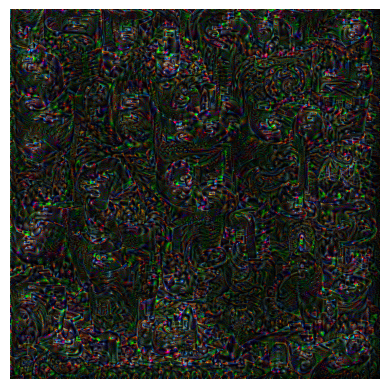

In [7]:
import torch
from torchvision import models, transforms
from torch.optim import Adam
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
model.eval()

transform = transforms.Compose([
    transforms.Resize((700, 700)),
    transforms.ToTensor(),
])

input_img = torch.full((1, 3, 700, 700), 0.3) + 0.05 * torch.randn(1, 3, 700, 700)
input_img.requires_grad = True

# Target class index for 'dumbbell' 
class_idx = 527

# Set up the optimizer
optimizer = Adam([input_img], lr=0.04, weight_decay=1e-6)
lambda_reg = 2e-3

# For monitoring loss and early stopping
prev_loss = float('inf')
loss_threshold = 1e-4  # Minimum change in loss to continue training
patience = 10  
patience_counter = 0

for i in range(600):  
    optimizer.zero_grad()
    output = model(input_img)
    current_loss = -output[0, class_idx]

    # L2 regularization
    l2_penalty = lambda_reg * torch.sum(input_img ** 2)
    total_loss = current_loss + l2_penalty

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Constraint the image to be between 0 and 1
    input_img.data.clamp_(0, 1)

    # Monitor the loss
    loss_change = abs(prev_loss - total_loss.item())
    if loss_change < loss_threshold:
        patience_counter += 1
        print(f"Iteration {i}: Loss = {total_loss.item()}, Change = {loss_change} (patience {patience_counter})")
        if patience_counter >= patience:
            print("Loss stabilized, stopping training.")
            break
    else:
        patience_counter = 0 
    
    prev_loss = total_loss.item()


output_img = transforms.ToPILImage()(input_img.squeeze(0).detach())
plt.imshow(output_img)
plt.axis('off')
plt.show()


# Saliency Map Visualization with VGG19

 - This is pretained in VGG19.
 - we compute the saliency map by performing a forward pass through the network, using the output to identify the class with the highest score, and computing the gradient of this score with respect to the input image. The absolute value of this gradient forms the saliency map, which we then visualize alongside the original image

C:\Users\VISHNU\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\VISHNU\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


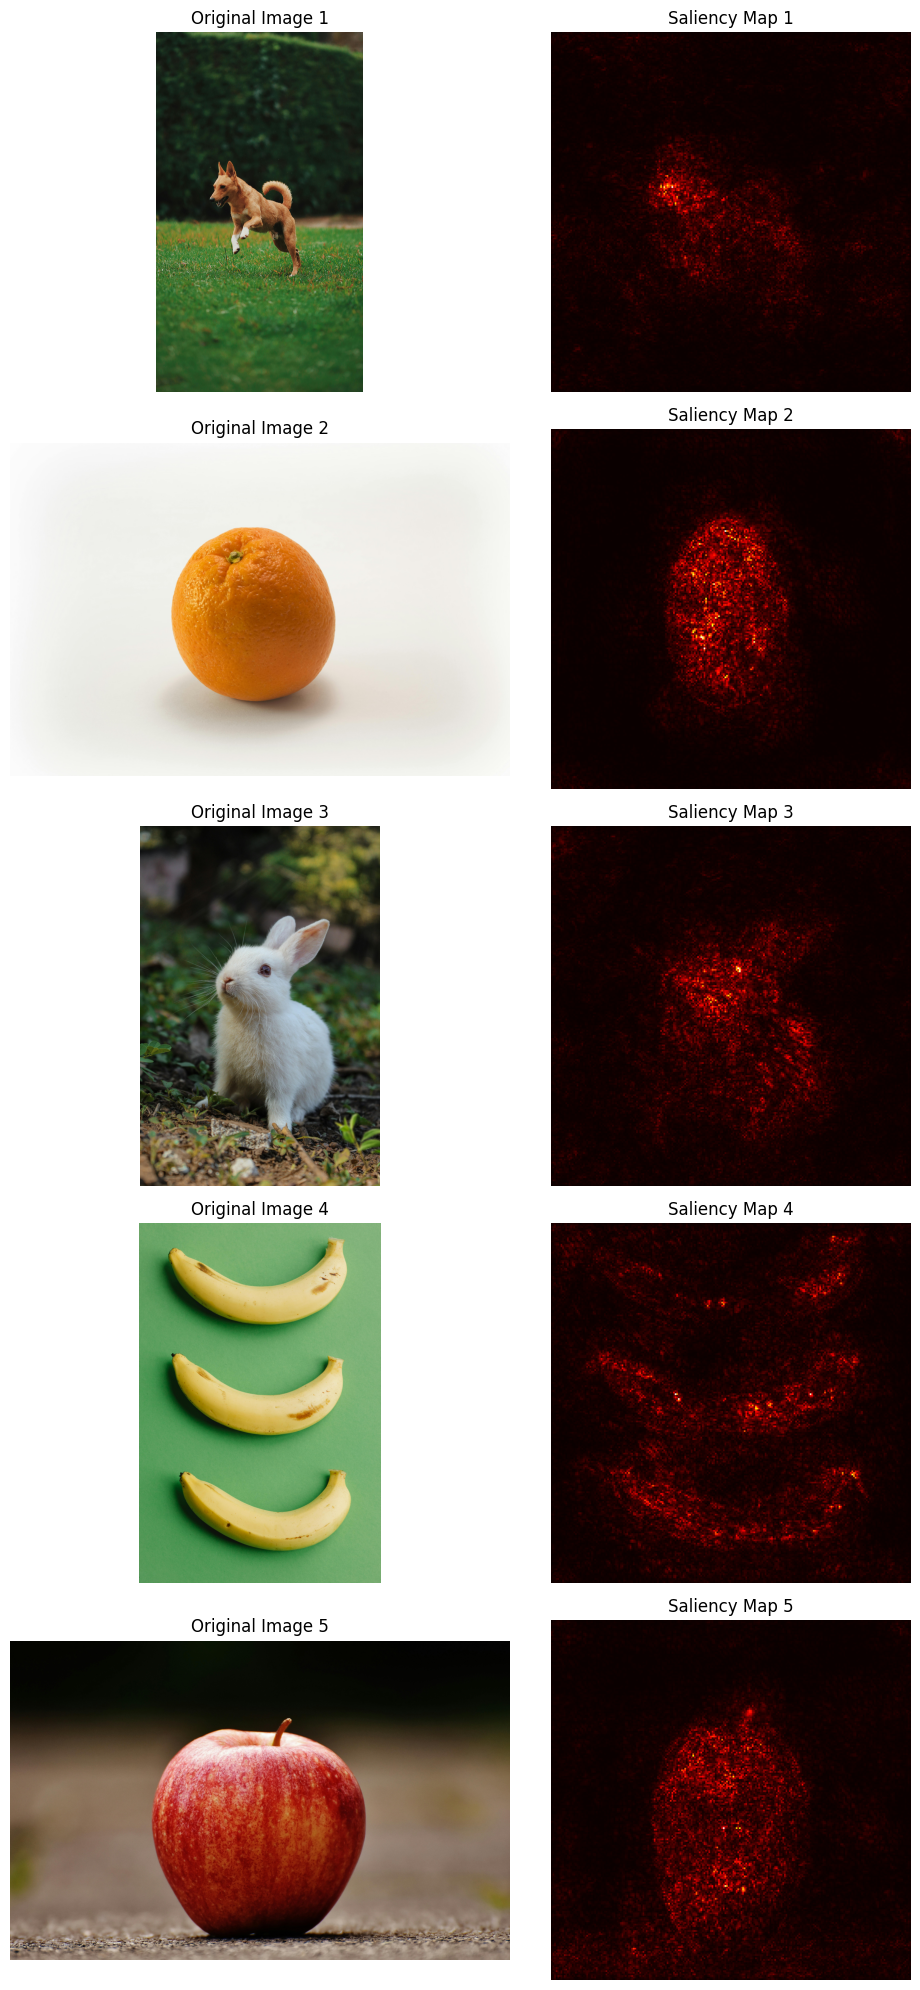

In [8]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load model and preprocess setup
model = models.vgg19(pretrained=True).eval()
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Paths to images
image_paths = [
    r"C:\Users\VISHNU\Downloads\pexels-bertellifotografia-1906153.jpg",
    r"C:\Users\VISHNU\Downloads\pexels-helioz-54369.jpg",
    r"C:\Users\VISHNU\Downloads\pexels-smpicturez-4001296.jpg",
    r"C:\Users\VISHNU\Downloads\pexels-any-lane-5946102.jpg",
    r"C:\Users\VISHNU\Downloads\pexels-pixabay-206959.jpg"
]

# Setup plot for 5 rows (one for each image pair), 2 columns (original and saliency)
fig, axes = plt.subplots(5, 2, figsize=(10, 20))  # Adjust figsize if necessary
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i, image_path in enumerate(image_paths):
    # Load and preprocess image
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0)
    img_tensor.requires_grad = True
    
    # Forward pass and compute gradients
    output = model(img_tensor)
    class_idx = output.argmax(dim=1).item()
    output[0, class_idx].backward()
    
    # Generate saliency map
    saliency = img_tensor.grad.data.abs().squeeze().sum(0)
    
    # Plot original image
    axes[2*i].imshow(img)  # 2*i indexes the first column for each row
    axes[2*i].axis('off')
    axes[2*i].set_title(f'Original Image {i+1}')
    
    # Plot saliency map
    axes[2*i + 1].imshow(saliency, cmap='hot')  # 2*i+1 indexes the second column for each row
    axes[2*i + 1].axis('off')
    axes[2*i + 1].set_title(f'Saliency Map {i+1}')

plt.tight_layout()
plt.show()


#  Weakly Supervised Object Localisation
 - Load a pretained model VGG19
 - Pre Process the Image 
 - The saliency map is obtained by taking the absolute sum of the gradients, which highlights the regions of the image most influential to the model's prediction.
 - Intiate a threshold of 95 where it is marked to 3 when its the top 5 important saliency or else to 2.
 - Do graphcut(using Grabcut) segnementation with the mask as an initialization and iteratively estimates which pixels belong to the foreground and which to the background based on color statistics and a graph representation.
 - Post process where the foreground is set to 1 and background to 0.

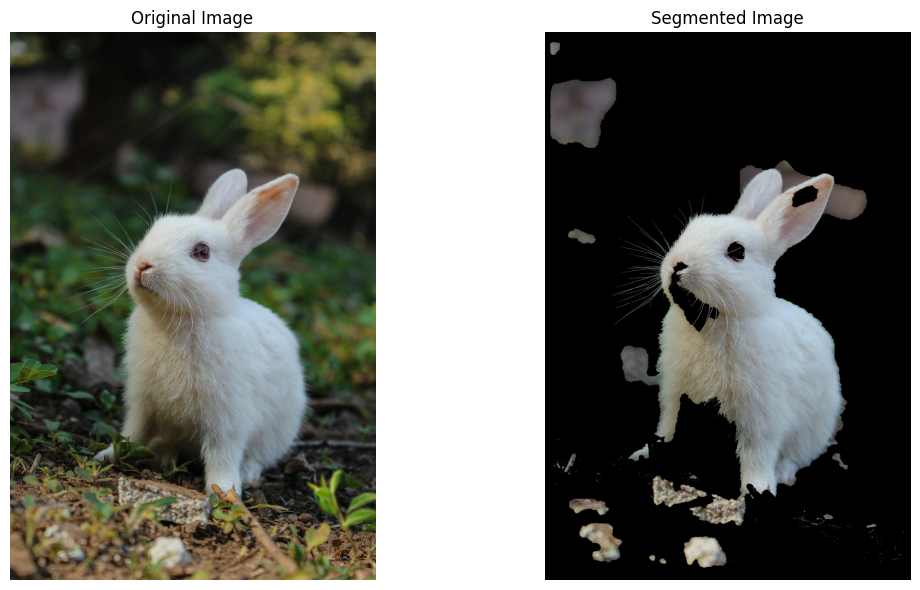

In [3]:
#Weakly Supervised Object Localisation
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import torch

# Path to the image
image_path = r"C:\Users\VISHNU\Downloads\pexels-smpicturez-4001296.jpg"
# Initialize the model and transformation
model = models.vgg16(pretrained=True).eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load and preprocess image
img = Image.open(image_path)
img_tensor = transform(img).unsqueeze(0)
img_tensor.requires_grad = True

# Forward pass and compute saliency
output = model(img_tensor)
class_idx = output.argmax(dim=1).item()
output[0, class_idx].backward() #gradient calculation
saliency = img_tensor.grad.data.abs().squeeze().sum(0)

# Convert the PIL image to NumPy array for OpenCV
img_array = np.array(img)

# Thresholding the saliency map
thresh = np.percentile(saliency.numpy(), 95)
_, thresholded = cv2.threshold(saliency.numpy(), thresh, 255, cv2.THRESH_BINARY)

# Apply GraphCut segmentation
mask = np.zeros(img_array.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
rect = (50, 50, img_array.shape[1] - 100, img_array.shape[0] - 100)

cv2.grabCut(img_array, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Process the mask to overlay with the original image
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img_display = img_array * mask2[:, :, np.newaxis]

# Plot original image and segmented result
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Original Image")

# Segmented Image
axes[1].imshow(img_display)
axes[1].axis('off')
axes[1].set_title("Segmented Image")

plt.tight_layout()
plt.show()



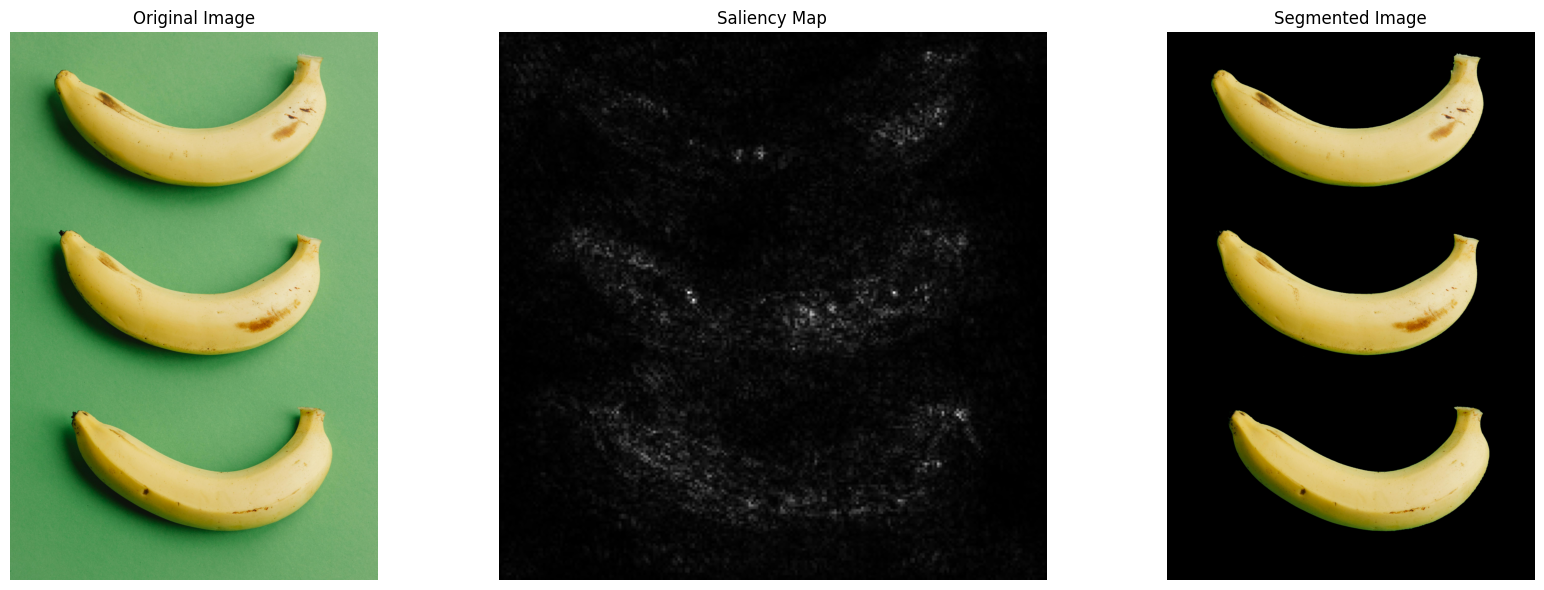

In [10]:
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms, models
import torch
import matplotlib.pyplot as plt

# Path to the image
image_path =r"C:\Users\VISHNU\Downloads\pexels-any-lane-5946102.jpg"
# Initialize the model and transformation
model = models.vgg19(pretrained=True).eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load and preprocess image
img = Image.open(image_path)
img_tensor = transform(img).unsqueeze(0)
img_tensor.requires_grad = True

# Forward pass and compute saliency
output = model(img_tensor)
class_idx = output.argmax(dim=1).item()
output[0, class_idx].backward()
saliency = img_tensor.grad.data.abs().squeeze().sum(0)

# Convert the PIL image to NumPy array for OpenCV
img_array = np.array(img.convert('RGB'))

# Thresholding the saliency map to create an initial mask
thresh = np.percentile(saliency.numpy(), 95)
mask = np.where(saliency.numpy() > thresh, 3, 2).astype('uint8')  # Create an initial mask

# Make sure the mask is the correct size
if mask.shape != img_array.shape[:2]:
    mask = cv2.resize(mask, (img_array.shape[1], img_array.shape[0]), interpolation=cv2.INTER_NEAREST)

# Prepare models for background and foreground
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Apply GraphCut segmentation
cv2.grabCut(img_array, mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

# Post-processing the mask to clean it up
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img_display = img_array * mask2[:, :, np.newaxis]

# Plot original image, saliency map, and segmented result
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(img_array)
axes[0].axis('off')
axes[0].set_title("Original Image")

# Saliency Map
axes[1].imshow(saliency.numpy(), cmap='gray')
axes[1].axis('off')
axes[1].set_title("Saliency Map")

# Segmented Image
axes[2].imshow(img_display)
axes[2].axis('off')
axes[2].set_title("Segmented Image")

plt.tight_layout()
plt.show()
